In [183]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import argparse
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

In [133]:
df = pd.read_csv("creditcard.csv")

In [134]:
df.shape

(284807, 31)

Text(0,0.5,u'Frequency')

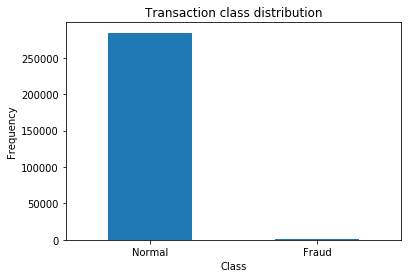

In [135]:
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [138]:
from sklearn.preprocessing import MinMaxScaler

data = df.drop(['Time'], axis=1)

#data['Amount'] = MinMaxScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [140]:
data.iloc[:,0:29] = MinMaxScaler().fit_transform(data.iloc[:,0:29].values.reshape(-1, 29))

In [124]:
MinMaxScaler().fit_transform(data.loc[:,['V1','V2']].values.reshape(-1, 2))

array([[ 0.93519234,  0.76649042],
       [ 0.97854195,  0.77006665],
       [ 0.93521702,  0.75311767],
       ..., 
       [ 0.99090481,  0.76407969],
       [ 0.954209  ,  0.77285574],
       [ 0.94923176,  0.7652564 ]])

In [193]:
y = data['Class']
X = data.iloc[:,0:29]

(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [194]:
(trainSet, testSet) = train_test_split(data, test_size = 0.2, random_state = 42)

In [195]:
df_majority = trainSet[trainSet.Class==0]
df_minority = trainSet[trainSet.Class==1]

In [235]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=60000,    # to match majority class
                                 random_state=123) # reproducible results

In [236]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [237]:
 # Display new class counts
df_upsampled.Class.value_counts()

0    227451
1     60000
Name: Class, dtype: int64

In [238]:
trainY = df_upsampled['Class']
trainX = df_upsampled.iloc[:,0:29]

testY = testSet['Class']
testX = testSet.iloc[:,0:29]

In [250]:
rbm = BernoulliRBM(n_components = 100, n_iter = 20, learning_rate = 0.06,  verbose = True)

logistic = LogisticRegression(C = 1.0)

# train the classifier and show an evaluation report
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
classifier.fit(trainX, trainY)

print classification_report(testY, classifier.predict(testX))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -17.29, time = 4.39s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -17.31, time = 7.20s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -17.35, time = 6.49s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -17.21, time = 6.45s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -17.15, time = 6.43s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -17.13, time = 6.41s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -17.28, time = 6.41s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -17.13, time = 6.41s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -16.97, time = 6.41s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -17.16, time = 6.40s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -17.04, time = 6.42s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -17.18, time = 6.43s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -17.15, time = 6.39s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -17.10, time = 6.43s
[BernoulliRBM] Iteration 15, 

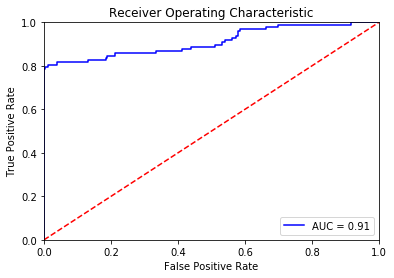

In [251]:
from sklearn.metrics import roc_curve, auc  
predictions = classifier.predict_proba(testX)  
false_positive_rate, recall, thresholds = roc_curve(testY, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Receiver Operating Characteristic')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()  

Text(0.5,1,u'2-class Precision-Recall curve: AP=0.66')

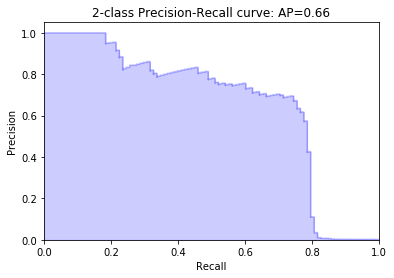

In [252]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

predictions = classifier.predict_proba(testX) 

average_precision = average_precision_score(testY, predictions[:, 1])

precision, recall, _ = precision_recall_curve(testY, predictions[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [255]:
logistic = LogisticRegression(C = 1.0)
logistic.fit(trainX, trainY)
print classification_report(testY, logistic.predict(testX))	

             precision    recall  f1-score   support

          0       1.00      0.99      1.00     56864
          1       0.21      0.87      0.33        98

avg / total       1.00      0.99      1.00     56962



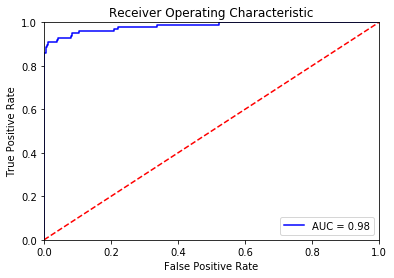

In [248]:
predictions = logistic.predict_proba(testX)  
false_positive_rate, recall, thresholds = roc_curve(testY, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Receiver Operating Characteristic')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()  

Text(0.5,1,u'2-class Precision-Recall curve: AP=0.74')

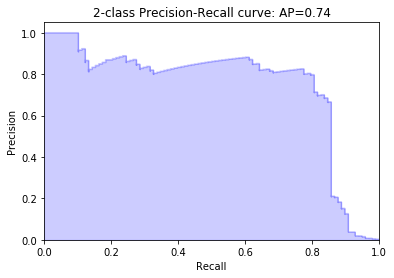

In [249]:
predictions = logistic.predict_proba(testX)

average_precision = average_precision_score(testY, predictions[:, 1])

precision, recall, _ = precision_recall_curve(testY, predictions[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [254]:
rbm = BernoulliRBM(n_components = 100, n_iter = 20,learning_rate = 0.06,  verbose = True)

logistic = LogisticRegression(C = 600.0)

# train the classifier and show an evaluation report
classifier_3 = Pipeline([("rbm", rbm), ("logistic", logistic)])
classifier_3.fit(trainX, trainY)

print classification_report(testY, classifier_3.predict(testX))


[BernoulliRBM] Iteration 1, pseudo-likelihood = -17.14, time = 4.39s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -17.14, time = 6.54s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -17.22, time = 6.53s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -17.08, time = 6.51s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -17.24, time = 6.48s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -17.02, time = 6.47s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -17.04, time = 6.46s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -17.16, time = 6.46s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -17.08, time = 6.45s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -17.13, time = 6.46s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -17.10, time = 6.45s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -16.97, time = 6.48s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -16.96, time = 6.45s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -17.11, time = 6.46s
[BernoulliRBM] Iteration 15, 

In [258]:
from sklearn.ensemble import VotingClassifier
# create the sub models
estimators = []
model1 = classifier
estimators.append(('logistic', model1))
model2 = logistic
estimators.append(('cart', model2))
# create the ensemble model
ensemble = VotingClassifier(estimators,voting='soft')

ensemble = ensemble.fit(trainX, trainY)

print classification_report(testY, ensemble.predict(testX))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -17.32, time = 4.42s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -17.18, time = 6.50s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -17.08, time = 6.46s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -17.29, time = 6.47s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -17.11, time = 6.44s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -17.20, time = 6.45s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -17.27, time = 6.44s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -17.04, time = 6.44s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -17.15, time = 7.15s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -17.02, time = 6.43s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -17.02, time = 6.41s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -17.09, time = 6.43s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -17.03, time = 6.80s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -17.08, time = 6.65s
[BernoulliRBM] Iteration 15, 

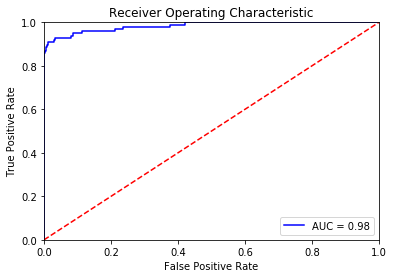

In [259]:
predictions = ensemble.predict_proba(testX)  
false_positive_rate, recall, thresholds = roc_curve(testY, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Receiver Operating Characteristic')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')  
plt.xlabel('False Positive Rate')  
plt.show()  